<a href="https://colab.research.google.com/github/chayvw18/Deep-Learning-PyTorch/blob/main/optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Deep-Learning/Regularization

/content/drive/MyDrive/Deep-Learning/Regularization


**What and where are optimizers?**
<br>

Optimizer refers to the algorithm that adjusts the weights during backprop
<br>

Outside of SGD, other optimizers are simply modifications of SGD, with the goal of smoothing the descent *learning is a little faster and little more efficent*
<br>

SGD: changes the weights after each sample. This is great when all samples are really similar to each other
<br>

But SGD learning is very sensitive, and can lead to volatile changes based on non representative samples
<br>

when giving a big loss the weights end up changing hugeky, the model changes too much. It overcompenstates for the non-repersentative data point / outlier
<br>

mini-batch training helps deal with the situation of non repersentative data.
<br>
Mini-batch SGD: Change the weights after N samples. Average losses across the N samples, sometimes more robust than SGD, expect when samples are similar to each other



**What is 'Momentum**
<br>
Smoothing via weighted averaging of data points
<br>
Each data point is a weighted combination of itself and the previous data point, sometimes called exponential average, becuase the weighting of the previous values are weighted less and less over time or as the training progresses.
<br>
**SGD with Momentum** Interpretation: Update current weights according to a weighted average of current and previvous costs *typical values of β are .9 to .99*
<br>
Momentum is not that fundamentally different from stochastic gradient descent. The only thing we are adding is taking a weighted average of previous cost functions or previous loss functions depending how much we are averaging
<br>


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

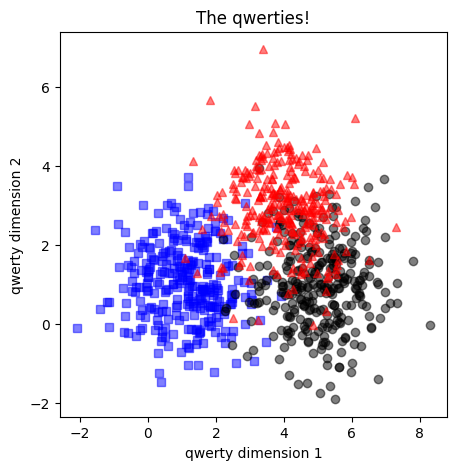

In [3]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [21]:
#create a class for the model
def createTheQwertyNet(momentum):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      #input layer
      self.input = nn.Linear(2,8)

      # hidden layer
      self.fc1 = nn.Linear(8,8)

      #output layer
      self.output = nn.Linear(8,3)

      #forward pass
      def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))

        return self.output(x)

      #create the model instance
  net = qwertyNet()

      #loss function
  lossFun = nn.CrossEntropyLoss()
      #
  optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=momentum)

  return net, lossFun, optimizer


In [22]:
optim = createTheQwertyNet(.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [24]:
#a function that trains the model

numepochs = 50

def function2trainTheModel(momentum):

  net,lossFun,optimizer = createTheQwertyNet(momentum)

  #initalize the losses
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []

  #loop
  for epochi in len(numepochs):

    #switch on training mode
    net.train()

    batchAcc = []
    batchLoss = []

    for X,y in train_loader:

      yhat = net(X)
      loss = lossFun(yhat, y)


      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
        # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net



In [25]:
momenta = [0, .5, .9, .95, .999]

#initalize results matrix
results = np.zeros((numepochs, len(momenta), 3))

#test all momentum values on the same data (different model instances)
for idx, mom in enumerate(momenta):
  trainAcc, testAcc, losses, net = function2trainTheModel(mom)
  results[:, idx, 0] = losses
  results[:, idx, 1] = trainAcc
  results[:, idx, 2] = testAcc

TypeError: object of type 'int' has no len()